In [11]:
import glob
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Extract features

### Single file example extraction

In [2]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size // 2)

def extract_feature_array(filename, bands=21, frames=41):
    window_size = 512 * (frames-1)
    mfccs = []
#     sound_clip, s = librosa.load(filename, sr=44100)
    for (start, end) in windows(sound_clip, window_size):
        start = int(start)
        end = int(end)
        if(len(sound_clip[start:end]) == window_size):
            signal = sound_clip[start:end]
            mfcc = librosa.feature.mfcc(signal, sr=s, n_mfcc=bands)
            mfccs.append(mfcc)
#             mfcc = librosa.feature.mfcc(signal, sr=s, n_mfcc=bands).T.flatten()[:, np.newaxis].T
#             logspec = librosa.logamplitude(melspec)
#     log_specgrams = np.expand_dims(np.asarray(log_specgrams), axis=3)
    return np.asarray(mfccs)

# # Uncomment if using deltas
#
#     log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
#     features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
#     for i in range(len(features)):
#         features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
#     return np.array(features)

# sample_filename = 'data/speech-accent-archive/recordings/afghanistan/dari2.mp3'
sample_filename = '/Users/leonmak/Documents/CS229/final-project/data/SC-scripted-word/CH/SC_W_CH_04_EN-chunk-5.wav'
features = extract_feature_array(sample_filename)
data_points, _ = librosa.load(sample_filename)
print ('IN: Initial Data Points =', len(data_points))
print ('OUT: Total features =', np.shape(features))


FileNotFoundError: [Errno 2] No such file or directory: '/Users/leonmak/Documents/CS229/final-project/data/SC-scripted-word/CH/SC_W_CH_04_EN-chunk-5.wav'

# Classes

In [14]:
from sklearn import preprocessing

def iter_label_files(parent_dir):
    """Utility for extracting labels"""
    for root, dirpaths, fnames in os.walk(parent_dir):
        if len(dirpaths) > 0:
            continue
        label = root.split('/')[-1]
        yield root, label, fnames

# parent_dir = 'data/speech-accent-archive/recordings/'
parent_dir = 'data/SC-word-segments/'
labels = []
for _, label, _ in iter_label_files(parent_dir):
    labels.append(label)
print(f'{len(labels)} labels found, First 10: {labels[:10]}')


10 labels found, First 10: ['CH', 'EN', 'IN', 'IR', 'JA', 'KO', 'MAF', 'RU', 'TH', 'TU']


In [15]:
cap = 7972
counts = []
for _, label, fnames in iter_label_files(parent_dir):
    counts.append(len(fnames))

top_indices_count = [i_count for i_count in sorted(enumerate(counts), key=lambda x:x[1], reverse=True)]
most_freq_egs = [labels[i] for (i, count) in top_indices_count if count >= cap]
print(f'Labels with >= {cap} egs: {most_freq_egs}, len:{len(most_freq_egs)}')    

le = preprocessing.LabelEncoder()
ohe = preprocessing.OneHotEncoder()
le_ed = le.fit_transform(most_freq_egs)
ohe_ed = ohe.fit_transform(le_ed.reshape(len(le_ed), 1))
print(ohe_ed.toarray())


Labels with >= 7972 egs: ['KO', 'EN', 'CH'], len:3
[[ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]


# Save features

In [29]:
import random 
import speechpy

NUM_MFCCS = 50
DEFAULT_BITRATE = 22050
DESIRED_DURATION = 1  # seconds
PADDED_LENGTH = DEFAULT_BITRATE * DESIRED_DURATION


def get_label_enc(fn, le):
    fn_parts = fn.split('/')
    label_txt = fn_parts[-2]  # y_i
    label_int = le.transform([label_txt])
    return label_int[0]


def normalize_audio(source_files):
    fixed_lengths = [librosa.util.fix_length(y, PADDED_LENGTH) for y, _ in source_files]
    return [(f - np.mean(f)) / np.std(f) for f in fixed_lengths]


def load_audio(source_files):
    loaded_mp3_files = [librosa.load(f) for f in source_files]
    fix_length_mp3 = normalize_audio(loaded_mp3_files)
    mfccs = [librosa.feature.mfcc(y=y, sr=DEFAULT_BITRATE, n_mfcc=NUM_MFCCS) for y in fix_length_mp3]
    return mfccs


def get_labels(fnames):
    labels = [get_label_enc(fn, le) for fn in fnames]
    return labels


def extract_feature(fnames):
    """
    Extract features from filenames to features and labels arrays
    """
    mfccs = load_audio(fnames)
    labels = get_labels(fnames)
    return np.asarray(mfccs), np.asarray(labels)
#     window_size = 512 * (frames-1)
#     log_specgrams = []
#     mfccs = []
#     labels = []
#     for fn in fnames:
#         sound_clip, s = librosa.load(fn)
# #         sound_clip -= np.mean(sound_clip)
# #         sound_clip /= max(sound_clip)
#         label_enc = get_label_enc(fn, le)
#         for (start, end) in windows(sound_clip, window_size):
#             signal = sound_clip[start:end]
#             if(len(signal) != window_size):
#                 break
#             labels.append(label_enc)
# #             melspec = librosa.feature.mfcc(signal, sr=s, n_mels=bands)
# #             logspec = librosa.logamplitude(melspec)
# #             log_specgrams.append(logspec)
#             mfcc = librosa.feature.mfcc(signal, sr=s, n_mfcc=bands)
#             mfccs.append(mfcc)
#     if word == False:
#         log_specgrams = np.expand_dims(np.asarray(log_specgrams), axis=3)
#     return np.asarray(mfccs), np.asarray(labels, dtype='int')
#     log_specgrams = np.array(log_specgrams).reshape(len(log_specgrams),bands,frames,2)
#     features = np.concatenate((log_specgrams, np.zeros(log_specgrams.shape)), axis=3)
#     for i in range(len(features)):
#         features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
#     return np.array(features), np.array(labels, dtype='int')


def get_subset_fnames():
    subset_fnames = []
    for root, label, fnames in iter_label_files(parent_dir):
        if label not in most_freq_egs:
            continue
        for fn in fnames[:cap]:
            if '.DS_Store' in fn:
                continue
            subset_fnames.append(os.path.join(root, fn))
    random.seed(24)
    random.shuffle(subset_fnames)
    return subset_fnames


def save_folds(save_dir, num_folds=10, fold_prefix='fold_orig_w'):
    fnames = get_subset_fnames()
    egs_per_fold = len(fnames) // num_folds
    curr = 0
    features = []
    labels = []
    for k in range(num_folds):
        fold_name = f'{fold_prefix}{str(k)}'
        
        feature_file = os.path.join(save_dir, fold_name + '_x.npy')
        labels_file = os.path.join(save_dir, fold_name + '_y.npy')

        print(f'Saving feature_file {feature_file} \nSaving labels_file {labels_file}')
        start_i = k * egs_per_fold
        end_i = (k + 1) * egs_per_fold
        fnames_fold = fnames[start_i: end_i]
        features, labels = extract_feature(fnames_fold)
#         features = np.concatenate([features, new_features]) if len(features) > 0 else np.asarray(new_features)
#         labels = np.concatenate([labels, new_labels]) if len(labels) > 0 else np.asarray(new_labels)
        print(f'Features of {fold_name} = {features.shape}')
        print(f'Labels of {fold_name} = {labels.shape}')

        np.save(feature_file, features)
        np.save(labels_file, labels)


save_dir=os.path.join('npy', 'mfcc_w')
save_folds(save_dir)


Saving feature_file npy/mfcc_w/fold_orig_w0_x.npy 
Saving labels_file npy/mfcc_w/fold_orig_w0_y.npy
Features of fold_orig_w0 = (2391, 50, 44)
Labels of fold_orig_w0 = (2391,)
Saving feature_file npy/mfcc_w/fold_orig_w1_x.npy 
Saving labels_file npy/mfcc_w/fold_orig_w1_y.npy
Features of fold_orig_w1 = (2391, 50, 44)
Labels of fold_orig_w1 = (2391,)
Saving feature_file npy/mfcc_w/fold_orig_w2_x.npy 
Saving labels_file npy/mfcc_w/fold_orig_w2_y.npy
Features of fold_orig_w2 = (2391, 50, 44)
Labels of fold_orig_w2 = (2391,)
Saving feature_file npy/mfcc_w/fold_orig_w3_x.npy 
Saving labels_file npy/mfcc_w/fold_orig_w3_y.npy
Features of fold_orig_w3 = (2391, 50, 44)
Labels of fold_orig_w3 = (2391,)
Saving feature_file npy/mfcc_w/fold_orig_w4_x.npy 
Saving labels_file npy/mfcc_w/fold_orig_w4_y.npy
Features of fold_orig_w4 = (2391, 50, 44)
Labels of fold_orig_w4 = (2391,)
Saving feature_file npy/mfcc_w/fold_orig_w5_x.npy 
Saving labels_file npy/mfcc_w/fold_orig_w5_y.npy
Features of fold_orig_w5 

# Load Features

In [19]:
from keras.utils import to_categorical
data_dir = os.path.join('npy', 'mfcc_w')
print(data_dir)
fold_prefix = 'fold_orig_w'

def add_folds(data_dir):
    files_lst = os.listdir(data_dir)
    num_folds = len(list(filter(lambda k: fold_prefix in k, files_lst))) // 2
        
    for k in range(num_folds-3):
        fold_name = f'{fold_prefix}{str(k)}'
        print("\nAdding " + fold_name)
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')

        loaded_features = np.load(feature_file)
        loaded_labels = np.load(labels_file)
        
        # Data Augmentation with Gaussian Noise
        noise = np.random.normal(0,1, loaded_features.shape)
        loaded_features = np.concatenate([loaded_features, loaded_features+noise])
        loaded_labels = np.concatenate([loaded_labels, loaded_labels])
        
        print("New Features: ", loaded_features.shape, loaded_labels.shape)
        if k > 0:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
    return features, labels

train_x, train_y = add_folds(data_dir)

# use a fold for train-dev
valid_fold_name = f'{fold_prefix}7'
feature_file = os.path.join(data_dir, valid_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, valid_fold_name + '_y.npy')
train_dev_x = np.load(feature_file)
train_dev_y = np.load(labels_file) 

# use a fold for dev
valid_fold_name = f'{fold_prefix}8'
feature_file = os.path.join(data_dir, valid_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, valid_fold_name + '_y.npy')
dev_x = np.load(feature_file)
dev_y = np.load(labels_file) 

# and a fold for testing
test_fold_name = f'{fold_prefix}9'
feature_file = os.path.join(data_dir, test_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, test_fold_name + '_y.npy')
test_x = np.load(feature_file)
test_y = np.load(labels_file)


# encode
train_y = to_categorical(train_y)
train_dev_y = to_categorical(train_dev_y)
dev_y = to_categorical(dev_y)
test_y = to_categorical(test_y)

# train_x = np.expand_dims(np.asarray(train_x), axis=3)
# train_dev_x = np.expand_dims(np.asarray(train_dev_x), axis=3)
# dev_x = np.expand_dims(np.asarray(dev_x), axis=3)
# test_x = np.expand_dims(np.asarray(test_x), axis=3)

# trim data
# last = min([len(train_x), len(train_dev_x), len(dev_x), len(test_x)])
# train_dev_x, train_dev_y = train_dev_x, train_dev_y
# dev_x, dev_y = dev_x[:last], dev_y[:last]
# test_x, test_y = test_x[:last], test_y[:last]

print(f"\nTraining Set: {train_x.shape}, Labels: {train_y.shape}")
print(f"Train-dev Set: {train_dev_x.shape}, Labels: {train_dev_y.shape}")
print(f"Dev Set: {dev_x.shape}, Labels: {dev_y.shape}")
print(f"Test Set: {test_x.shape}, Labels: {test_y.shape}")


npy/mfcc_w

Adding fold_orig_w0
New Features:  (4782, 50, 44) (4782,)

Adding fold_orig_w1
New Features:  (4782, 50, 44) (4782,)

Adding fold_orig_w2
New Features:  (4782, 50, 44) (4782,)

Adding fold_orig_w3
New Features:  (4782, 50, 44) (4782,)

Adding fold_orig_w4
New Features:  (4782, 50, 44) (4782,)

Adding fold_orig_w5
New Features:  (4782, 50, 44) (4782,)

Adding fold_orig_w6
New Features:  (4782, 50, 44) (4782,)

Training Set: (33474, 50, 44), Labels: (33474, 3)
Train-dev Set: (2391, 50, 44), Labels: (2391, 3)
Dev Set: (2391, 50, 44), Labels: (2391, 3)
Test Set: (2391, 50, 44), Labels: (2391, 3)


In [16]:
tf.set_random_seed(0)
np.random.seed(0)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D, MaxPool1D, MaxPool2D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from keras.metrics import categorical_accuracy
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.regularizers import l2
from keras.utils import np_utils
from librosa.util import fix_length

bands = 50
frames = 1077
feature_size = bands * frames
num_labels = len(most_freq_egs)
input_shape = (bands, frames)
# input_shape=(bands, frames, num_channels) # if have delta num_channels = 1


def build_model():
    model = Sequential()
    kernel = (3, 3)
    model.add(Conv2D(32, kernel, activation='relu', input_shape=(50, 44, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Conv2D(64, kernel, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels, activation='softmax', kernel_regularizer=l2(0.001)))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    return model
print("Building model...")
model = build_model()
model.summary()


In [89]:
print("Training model...")
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
train_plus_dev_x = np.concatenate([train_x, train_dev_x])
train_plus_dev_y = np.concatenate([train_y, train_dev_y])

history = model.fit(train_plus_dev_x.reshape(train_plus_dev_x.shape[0], train_plus_dev_x.shape[1], train_plus_dev_x.shape[2], 1), 
                    train_plus_dev_y, 
                    validation_data=(dev_x.reshape(dev_x.shape[0], dev_x.shape[1], dev_x.shape[2], 1), dev_y), 
                    callbacks=[earlystop], 
                    epochs=30)

Training model...
Train on 35865 samples, validate on 2391 samples
Epoch 1/30
35865/35865 [==============================] - 380s 11ms/step - loss: 1.3561 - acc: 0.5451 - val_loss: 0.9240 - val_acc: 0.7445
Epoch 2/30
35865/35865 [==============================] - 361s 10ms/step - loss: 1.0167 - acc: 0.6964 - val_loss: 0.8845 - val_acc: 0.7946
Epoch 3/30
35865/35865 [==============================] - 369s 10ms/step - loss: 0.9707 - acc: 0.7491 - val_loss: 0.8505 - val_acc: 0.8243
Epoch 4/30
35865/35865 [==============================] - 347s 10ms/step - loss: 0.9536 - acc: 0.7765 - val_loss: 0.9159 - val_acc: 0.8114
Epoch 5/30
35865/35865 [==============================] - 346s 10ms/step - loss: 0.9468 - acc: 0.7967 - val_loss: 0.8467 - val_acc: 0.8545
Epoch 6/30
35865/35865 [==============================] - 351s 10ms/step - loss: 0.9170 - acc: 0.8136 - val_loss: 0.7990 - val_acc: 0.8653
Epoch 7/30
35865/35865 [==============================] - 357s 10ms/step - loss: 0.9160 - acc: 0.81

# K-fold cross validation

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

num_splits=3
cnn_estimator = KerasClassifier(build_fn=build_model, epochs=15, batch_size=50, verbose=1)
kfold = KFold(n_splits=num_splits, shuffle=True, random_state=1)
results = cross_val_score(cnn_estimator, train_x, train_y, cv=kfold)
print("{num_splits}-fold xval accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

## Examine Predictions

In [94]:
from sklearn.metrics import roc_auc_score

def evaluate(model):
    y_prob = model.predict_proba(test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2], 1), verbose=0)
    print(y_prob)
    y_pred = model.predict(test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2], 1))
    print(f'pred: {np.argmax(y_pred[:100],axis=1)}')
    y_true = np.argmax(test_y)
    print(f'test: {np.argmax(test_y[:100],axis=1)}')

    # evaluate the model
    score, accuracy = model.evaluate(test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2], 1), test_y)
    print("Accuracy = {:.2f}".format(accuracy))
    
    return accuracy

# now evaluate the trained model against the unseen test data
print("Evaluating model...")
acc = evaluate(model)


Evaluating model...
[[  9.78253186e-01   9.09804832e-03   1.26486756e-02]
 [  1.15282424e-01   2.03640724e-04   8.84513915e-01]
 [  4.24409099e-02   9.28096831e-01   2.94622798e-02]
 ..., 
 [  1.72903836e-01   1.71733633e-01   6.55362546e-01]
 [  9.98915911e-01   3.84449922e-05   1.04562344e-03]
 [  9.92564678e-01   9.95351467e-04   6.43992983e-03]]
pred: [0 2 1 0 1 0 1 2 1 1 1 0 0 0 0 2 1 2 1 1 2 2 1 2 2 2 0 0 1 0 1 1 1 1 2 0 2
 2 2 0 0 0 2 1 2 2 0 0 1 2 0 1 0 1 2 2 2 0 1 2 0 2 2 2 2 2 0 0 2 1 2 2 2 2
 2 1 2 0 2 1 2 2 0 2 2 2 2 1 0 1 2 2 0 1 2 1 2 0 1 1]
test: [0 2 1 2 1 0 1 2 1 1 1 0 0 0 0 2 1 2 1 1 2 2 1 0 2 1 2 0 1 0 1 1 1 1 2 0 2
 2 2 0 0 0 0 1 2 2 0 2 1 2 0 1 0 1 2 2 0 0 1 2 0 2 0 2 2 2 0 0 2 1 2 2 2 2
 2 1 2 0 2 1 2 2 0 2 2 2 2 1 0 1 2 2 0 1 2 1 2 0 1 1]
2391/2391 [==============================] - 10s 4ms/step
Accuracy = 0.88


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


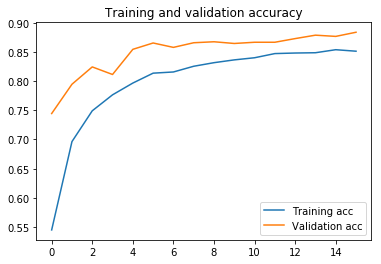

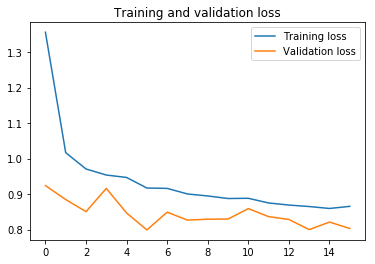

In [95]:
# import matplotlib.pyplot as plt
print(history.history.keys())
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [75]:
cnnmodel = model

NameError: name 'model' is not defined

# Error Analysis
Noise got extracted as a segment

In [77]:
mistake_file = 'data/SC-word-segments/EN/SC_W_ENF_17_EN-101.16-101.34.wav'
y, sr = librosa.load(mistake_file)
y = librosa.util.fix_length(y, 22050)
mfccs = librosa.feature.mfcc(y=y, sr=22050, n_mfcc=50)
x_mistake = np.array([mfccs])
x_mistake = np.expand_dims(np.asarray(x_mistake), axis=3)
y_m_pred = cnnmodel.predict(x_mistake.reshape(x_mistake.shape[0], x_mistake.shape[1]*x_mistake.shape[2]))
y_m_pred_c = le.classes_[np.argmax(y_m_pred)]
y_m_pred_c

'KO'

# RNN

In [71]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, GRU
from keras.layers import Conv1D, Conv2D, MaxPool1D, MaxPool2D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from keras.metrics import categorical_accuracy
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.regularizers import l2
from keras.utils import np_utils
from librosa.util import fix_length

def rnn_model():        
    model = Sequential()
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_shape=(50, 44)))
    model.add(Dense(num_labels, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model

print("Building model...")
rnnmodel = rnn_model()
rnnmodel.summary()


Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 128)               88576     
_________________________________________________________________
dense_59 (Dense)             (None, 3)                 387       
Total params: 88,963
Trainable params: 88,963
Non-trainable params: 0
_________________________________________________________________


In [72]:
print("Training model...")
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = rnnmodel.fit(np.concatenate([train_x, train_dev_x]), 
                    np.concatenate([train_y, train_dev_y]), 
                    validation_data=(dev_x, dev_y), 
                    callbacks=[earlystop],
                    batch_size=1024, 
                    epochs=30)

Training model...
Train on 35865 samples, validate on 2391 samples
Epoch 1/30
35865/35865 [==============================] - 56s 2ms/step - loss: 1.0809 - acc: 0.4189 - val_loss: 1.0344 - val_acc: 0.4496
Epoch 2/30
35865/35865 [==============================] - 54s 2ms/step - loss: 1.0200 - acc: 0.4746 - val_loss: 1.0120 - val_acc: 0.4772
Epoch 3/30
35865/35865 [==============================] - 48s 1ms/step - loss: 0.9940 - acc: 0.4975 - val_loss: 0.9950 - val_acc: 0.4956
Epoch 4/30
35865/35865 [==============================] - 46s 1ms/step - loss: 0.9693 - acc: 0.5221 - val_loss: 0.9756 - val_acc: 0.5140
Epoch 5/30
35865/35865 [==============================] - 46s 1ms/step - loss: 0.9453 - acc: 0.5422 - val_loss: 0.9545 - val_acc: 0.5341
Epoch 6/30
35865/35865 [==============================] - 46s 1ms/step - loss: 0.9261 - acc: 0.5588 - val_loss: 0.9357 - val_acc: 0.5412
Epoch 7/30
35865/35865 [==============================] - 55s 2ms/step - loss: 0.9058 - acc: 0.5731 - val_loss:

KeyboardInterrupt: 

In [37]:
from sklearn.metrics import roc_auc_score

def evaluate(model):
    y_prob = model.predict_proba(test_x, verbose=0)
    print(y_prob)
    y_pred = model.predict(test_x)
    print(f'pred: {np.argmax(y_pred[:100],axis=1)}')
    y_true = np.argmax(test_y)
    print(f'test: {np.argmax(test_y[:100],axis=1)}')

    # evaluate the model
    score, accuracy = model.evaluate(test_x, test_y)
    print("Accuracy = {:.2f}".format(accuracy))
    
    return accuracy

# now evaluate the trained model against the unseen test data
print("Evaluating model...")
acc = evaluate(rnnmodel)


Evaluating model...
[[ 0.35700294  0.04510209  0.59789503]
 [ 0.49178138  0.18662235  0.32159638]
 [ 0.42248237  0.38264278  0.19487485]
 ..., 
 [ 0.3222174   0.05663912  0.62114346]
 [ 0.43648264  0.2678397   0.29567766]
 [ 0.4063268   0.41018021  0.18349297]]
pred: [2 0 0 1 1 2 0 0 1 0 2 1 0 0 2 2 1 2 1 0 1 1 1 2 2 0 1 0 1 1 1 2 1 0 1 2 2
 0 2 1 0 2 1 1 1 2 1 2 0 1 2 1 0 2 2 1 2 2 0 2 1 0 0 0 1 1 1 1 1 0 2 0 1 2
 2 1 1 2 2 0 2 2 0 1 0 1 1 1 2 2 1 2 2 1 1 1 2 0 2 0]
test: [0 2 1 2 1 0 1 2 1 1 1 0 0 0 0 2 1 2 1 1 2 2 1 0 2 1 2 0 1 0 1 1 1 1 2 0 2
 2 2 0 0 0 0 1 2 2 0 2 1 2 0 1 0 1 2 2 0 0 1 2 0 2 0 2 2 2 0 0 2 1 2 2 2 2
 2 1 2 0 2 1 2 2 0 2 2 2 2 1 0 1 2 2 0 1 2 1 2 0 1 1]
2391/2391 [==============================] - 1s 360us/step
Accuracy = 0.45


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


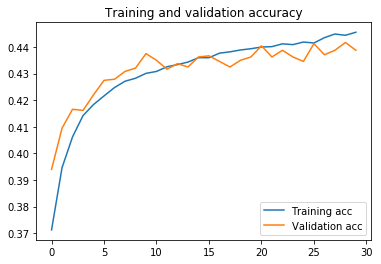

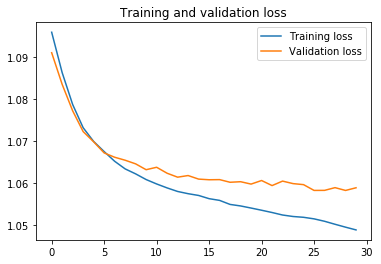

In [27]:
# import matplotlib.pyplot as plt
print(history.history.keys())
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [59]:
def mlp_model():        
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(50*44,), kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.1))
    model.add(Dense(num_labels, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model

print("Building model...")
mlpmodel = mlp_model()
mlpmodel.summary()


Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 128)               281728    
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 3)                 387

In [60]:
print("Training model...")
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

true_train_x = np.concatenate([train_x, train_dev_x])
true_train_y = np.concatenate([train_y, train_dev_y])
history = mlpmodel.fit(true_train_x.reshape(true_train_x.shape[0], true_train_x.shape[1]*true_train_x.shape[2]), 
                    true_train_y, 
                    validation_data=(dev_x.reshape(dev_x.shape[0], dev_x.shape[1]*dev_x.shape[2]), dev_y), 
                    callbacks=[earlystop], 
                    shuffle=True,
                    epochs=30)

Training model...
Train on 35865 samples, validate on 2391 samples
Epoch 1/30
35865/35865 [==============================] - 13s 376us/step - loss: 2.8714 - acc: 0.5069 - val_loss: 1.1994 - val_acc: 0.6240
Epoch 2/30
35865/35865 [==============================] - 12s 329us/step - loss: 1.0825 - acc: 0.6558 - val_loss: 0.9808 - val_acc: 0.6880
Epoch 3/30
35865/35865 [==============================] - 14s 402us/step - loss: 0.8894 - acc: 0.7215 - val_loss: 0.9041 - val_acc: 0.7056
Epoch 4/30
35865/35865 [==============================] - 14s 397us/step - loss: 0.7850 - acc: 0.7538 - val_loss: 0.8401 - val_acc: 0.7202
Epoch 5/30
35865/35865 [==============================] - 13s 370us/step - loss: 0.7339 - acc: 0.7689 - val_loss: 0.8244 - val_acc: 0.7407
Epoch 6/30
35865/35865 [==============================] - 15s 416us/step - loss: 0.6961 - acc: 0.7861 - val_loss: 0.8060 - val_acc: 0.7365
Epoch 7/30
35865/35865 [==============================] - 15s 425us/step - loss: 0.6693 - acc: 0.79

In [61]:
from sklearn.metrics import roc_auc_score

def evaluate(model):
    y_prob = model.predict_proba(test_x.reshape(test_x.shape[0], test_x.shape[1]*test_x.shape[2]), verbose=0)
    print(y_prob)
    y_pred = model.predict(test_x.reshape(test_x.shape[0], test_x.shape[1]*test_x.shape[2]))
    print(f'pred: {np.argmax(y_pred[:100],axis=1)}')
    y_true = np.argmax(test_y)
    print(f'test: {np.argmax(test_y[:100],axis=1)}')

    # evaluate the model
    score, accuracy = model.evaluate(test_x.reshape(test_x.shape[0], test_x.shape[1]*test_x.shape[2]), test_y)
    print("Accuracy = {:.2f}".format(accuracy))
    
    return accuracy

# now evaluate the trained model against the unseen test data
print("Evaluating model...")
acc = evaluate(mlpmodel)


Evaluating model...
[[  1.61153264e-02   9.60743606e-01   2.31410451e-02]
 [  8.57988715e-01   3.59800360e-05   1.41975239e-01]
 [  5.51784132e-03   5.35130501e-01   4.59351689e-01]
 ..., 
 [  1.61743715e-01   2.46548787e-01   5.91707528e-01]
 [  9.97423530e-01   3.96655305e-05   2.53678369e-03]
 [  9.87039149e-01   9.64461244e-04   1.19963977e-02]]
pred: [1 0 1 2 1 0 1 2 1 1 1 0 0 0 0 2 1 2 1 1 2 1 1 2 2 2 0 0 1 0 1 1 1 1 2 0 2
 2 2 0 0 0 0 1 2 0 0 0 1 2 1 1 0 1 2 2 0 2 1 2 0 2 2 2 2 2 0 2 2 1 2 2 2 2
 2 1 2 0 2 1 2 2 0 2 2 2 2 2 2 1 0 0 0 1 1 1 2 0 1 1]
test: [0 2 1 2 1 0 1 2 1 1 1 0 0 0 0 2 1 2 1 1 2 2 1 0 2 1 2 0 1 0 1 1 1 1 2 0 2
 2 2 0 0 0 0 1 2 2 0 2 1 2 0 1 0 1 2 2 0 0 1 2 0 2 0 2 2 2 0 0 2 1 2 2 2 2
 2 1 2 0 2 1 2 2 0 2 2 2 2 1 0 1 2 2 0 1 2 1 2 0 1 1]
2391/2391 [==============================] - 0s 111us/step
Accuracy = 0.80


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


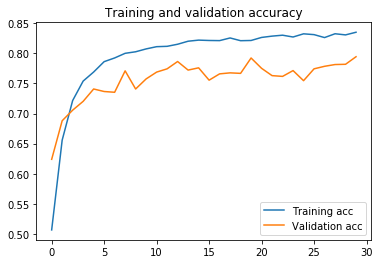

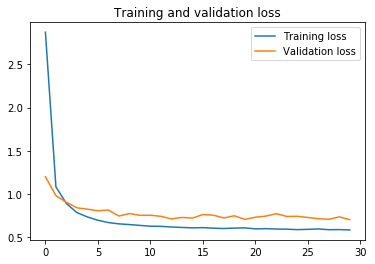

In [62]:
# import matplotlib.pyplot as plt
print(history.history.keys())
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Train SVM

In [ ]:
C_params = [0.1, 10, 25, 50, 100, 200, 500]
accuracies = [0, 0, 0, 0, 0, 0, 0]

In [ ]:
np.argmax(train_y, axis=1)

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

train_plus_dev_x = np.concatenate([train_x, train_dev_x])
train_plus_dev_y = np.concatenate([train_y, train_dev_y])

for idx, C_param in enumerate(C_params):
    svm_rbf = SVC(C=C_param, kernel='rbf', probability=True)
    svm_rbf.fit(train_plus_dev_x.reshape(train_plus_dev_x.shape[0], train_plus_dev_x.shape[1]*train_plus_dev_x.shape[2]), np.argmax(train_plus_dev_y, axis=1))
    y_test_predict = svm_rbf.predict(test_x.reshape(test_x.shape[0], test_x.shape[1]*test_x.shape[2]))
    accuracies[idx] = accuracy_score(y_true=np.argmax(test_y,axis=1), y_pred=y_test_predict)
    print(accuracies[idx])
print(accuracies)

## Train Random Forest

In [34]:
C_params = [10, 25, 50, 100, 200, 500]
accuracies = [0, 0, 0, 0, 0, 0]

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

train_plus_dev_x = np.concatenate([train_x, train_dev_x])
train_plus_dev_y = np.concatenate([train_y, train_dev_y])

for idx, C_param in enumerate(C_params):
    rf = RandomForestClassifier(n_estimators=C_param)
    rf.fit(train_plus_dev_x.reshape(train_plus_dev_x.shape[0], train_plus_dev_x.shape[1]*train_plus_dev_x.shape[2]), np.argmax(train_plus_dev_y, axis=1))
    y_test_predict = rf.predict(test_x.reshape(test_x.shape[0], test_x.shape[1]*test_x.shape[2]))
    accuracies[idx] = accuracy_score(y_true=np.argmax(test_y,axis=1), y_pred=y_test_predict)
    print(accuracies[idx])
print(accuracies)

0.554997908825
0.612714345462
0.639899623588
0.656210790464
0.686741948975
0.690506064408
[0.55499790882475952, 0.61271434546214976, 0.63989962358845676, 0.65621079046424091, 0.68674194897532415, 0.6905060644081974]


## Train Gradient Boosting

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

C_params = [10, 25, 50, 100, 200, 500]
accuracies = [0, 0, 0, 0, 0, 0]
for idx, C_param in enumerate(C_params):
    gb = GradientBoostingClassifier(n_estimators=C_param)
    gb.fit(train_plus_dev_x.reshape(train_plus_dev_x.shape[0], train_plus_dev_x.shape[1]*train_plus_dev_x.shape[2]), np.argmax(train_plus_dev_y, axis=1))
    y_test_predict = rf.predict(test_x.reshape(test_x.shape[0], test_x.shape[1]*test_x.shape[2]))
    accuracies[idx] = accuracy_score(y_true=np.argmax(test_y,axis=1), y_pred=y_test_predict)
    print(accuracies[idx])
print(accuracies)

0.690506064408


KeyboardInterrupt: 